In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
train = pd.read_csv("train_final.csv", index_col=['date'], parse_dates=['date'])
test = pd.read_csv("test_final.csv", index_col=['date'], parse_dates=['date'])

In [3]:
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]
train = train[['new_confirmed','country_code','location_key_x','new_deceased', 'cumulative_deceased', 'population', 'population_male', 'population_female', 'latitude', 'longitude','area_sq_km', 'life_expectancy', 'mobility_workplaces', 'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated', 'gdp_per_capita_usd','day_of_week', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
test = test[['new_confirmed','new_deceased','country_code','location_key_x', 'cumulative_deceased', 'population', 'population_male', 'population_female', 'latitude', 'longitude','area_sq_km', 'life_expectancy', 'mobility_workplaces', 'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated', 'gdp_per_capita_usd','day_of_week', 'quarter', 'month', 'year', 'dayofyear' ,'dayofmonth', 'weekofyear']]
#train = train.drop(['day_name','season','Unnamed: 0.1','Unnamed: 0','new_confirmed_std1','new_confirmed_lag7','new_confirmed_min7','new_confirmed_mean7','new_confirmed_std7','new_confirmed_max7','new_confirmed_lag3','new_confirmed_mean3','new_confirmed_min3','new_confirmed_max3','new_confirmed_std3','new_confirmed_lag1'],axis=1)
#test = test.drop(['day_name','season','Unnamed: 0.1','Unnamed: 0','new_confirmed_std1','new_confirmed_lag7','new_confirmed_min7','new_confirmed_mean7','new_confirmed_std7','new_confirmed_max7','new_confirmed_lag3','new_confirmed_mean3','new_confirmed_min3','new_confirmed_max3','new_confirmed_std3','new_confirmed_lag1'],axis=1)

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import prophet

In [5]:
# build the model with one coutry with highest GDP per capita in each continent
# if data of multiple regions are available, use one region
# then apply the model to other countries in same continent
Luxembourg_train = train.loc[train.country_code == 'LU'] # Europe
Luxembourg_train = Luxembourg_train.drop(['country_code','location_key_x'],axis=1)
Singapore_train = train.loc[train.country_code == 'SG'] # Asia
Singapore_train = Singapore_train.drop(['country_code','location_key_x'],axis=1)
US_train = train.loc[train.location_key_x == 'US_AK'] # North America
US_train = US_train.drop(['country_code','location_key_x'],axis=1)
Australia_train = train.loc[train.location_key_x == 'AU_NT'] #Oceania
Australia_train = Australia_train.drop(['country_code','location_key_x'],axis=1)
Luxembourg_test = test.loc[test.country_code == 'LU']
Luxembourg_test = Luxembourg_test.drop(['country_code','location_key_x'],axis=1)
Singapore_test = test.loc[test.country_code == 'SG']
Singapore_test = Singapore_test.drop(['country_code','location_key_x'],axis=1)
US_test = test.loc[test.location_key_x == 'US_AK']
US_test = US_test.drop(['country_code','location_key_x'],axis=1)
Australia_test = test.loc[test.location_key_x == 'AU_NT']
Australia_test = Australia_test.drop(['country_code','location_key_x'],axis=1)

In [6]:
def process(df):
    df.insert(1, 'lag1_new_confirmed', df['new_confirmed'].shift(1).fillna(0))
    return df
Luxembourg_train=process(Luxembourg_train)
Luxembourg_test=process(Luxembourg_test)
print(Luxembourg_train.shape, Luxembourg_test.shape)

(644, 22) (256, 22)


In [7]:
# log data
from scipy.stats import norm, skew
log_Luxembourg_train = np.log1p(Luxembourg_train)
log_Luxembourg_test = np.log1p(Luxembourg_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [8]:
log_Luxembourg_train.isnull().sum().sort_values(ascending = False)

mobility_workplaces                    560
lag1_new_confirmed                       0
dayofmonth                               0
dayofyear                                0
year                                     0
month                                    0
quarter                                  0
day_of_week                              0
gdp_per_capita_usd                       0
cumulative_persons_fully_vaccinated      0
new_persons_fully_vaccinated             0
new_confirmed                            0
life_expectancy                          0
area_sq_km                               0
longitude                                0
latitude                                 0
population_female                        0
population_male                          0
population                               0
cumulative_deceased                      0
new_deceased                             0
weekofyear                               0
dtype: int64

In [9]:
log_Luxembourg_train = log_Luxembourg_train.drop(['mobility_workplaces'],axis=1)
log_Luxembourg_test = log_Luxembourg_test.drop(['mobility_workplaces'],axis=1)

In [10]:
model = prophet.Prophet(daily_seasonality=True)

for col in log_Luxembourg_train.columns:
    if col not in ['date', 'new_confirmed']:
        model.add_regressor(col)
model.add_seasonality(name='monthly', period=30, fourier_order=5)
Luxembourg_model=model.fit(log_Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/p9mp8koz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/nuyv12nv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72994', 'data', 'file=/tmp/tmp74ow6a8v/p9mp8koz.json', 'init=/tmp/tmp74ow6a8v/nuyv12nv.json', 'output', 'file=/tmp/tmp74ow6a8v/prophet_model2ie34023/prophet_model-20231126125412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:54:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


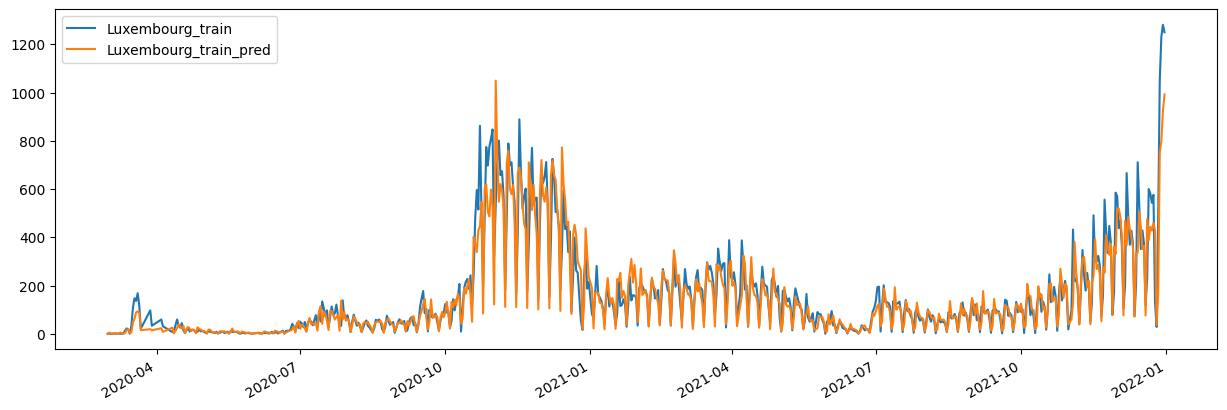

In [11]:
Luxembourg_train_pred=np.exp(Luxembourg_model.predict(log_Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
pd.concat([Luxembourg_train['new_confirmed'],Luxembourg_train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['Luxembourg_train', 'Luxembourg_train_pred'])

In [12]:
# Luxerberg model training rmse without tuning
np.sqrt(mean_squared_error(Luxembourg_train['new_confirmed'],Luxembourg_train_pred.yhat))

81.54057387939405

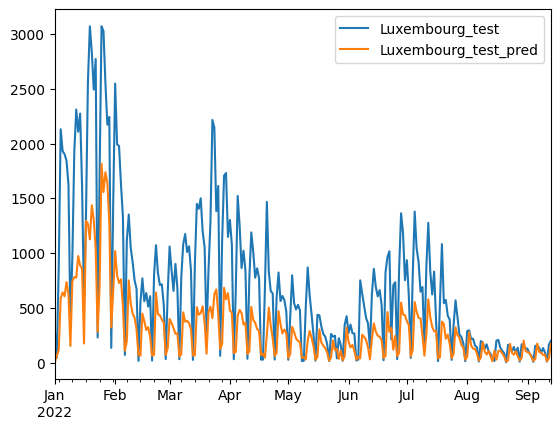

In [13]:
Luxembourg_test_pred=np.exp(Luxembourg_model.predict(log_Luxembourg_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
pd.concat([Luxembourg_test['new_confirmed'],Luxembourg_test_pred['yhat']], axis=1).plot( )
plt.legend(['Luxembourg_test', 'Luxembourg_test_pred'])

In [14]:
# Luxerberg model teset rmse without tuning
np.sqrt(mean_squared_error(Luxembourg_test['new_confirmed'],Luxembourg_test_pred['yhat']))

588.2987263000566

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

cutoffs = pd.to_datetime(['2020-10-01', '2021-05-01', '2021-12-01'])
param_grid_option = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 10.0]}

all_params_combination = [dict(zip(param_grid_option.keys(), v)) for v in itertools.product(*param_grid_option.values())]
rmses = []

for parameters in all_params_combination:
    prophet_model = prophet.Prophet(**parameters,daily_seasonality=True).fit(log_Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    Luxembourg_cv = cross_validation(prophet_model, horizon='30 days', parallel="processes")
    Luxembourg_performance = performance_metrics(Luxembourg_cv, rolling_window=1)
    rmses.append(Luxembourg_performance['rmse'].values[0])

best_params = all_params_combination[np.argmin(rmses)]

In [49]:
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0}


In [50]:
# Luxembourg model after tuning

Luxembourg_model_final = prophet.Prophet(changepoint_prior_scale = 0.05, seasonality_prior_scale = 1,daily_seasonality=True).fit(log_Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Luxembourg_train_pred_final=np.exp(Luxembourg_model_final.predict(log_Luxembourg_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
Luxembourg_test_pred_final=np.exp(Luxembourg_model_final.predict(log_Luxembourg_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/g2pau9sx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/0o569qwi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97145', 'data', 'file=/tmp/tmp74ow6a8v/g2pau9sx.json', 'init=/tmp/tmp74ow6a8v/0o569qwi.json', 'output', 'file=/tmp/tmp74ow6a8v/prophet_modelq9cc7q3s/prophet_model-20231126130604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:06:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:06:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


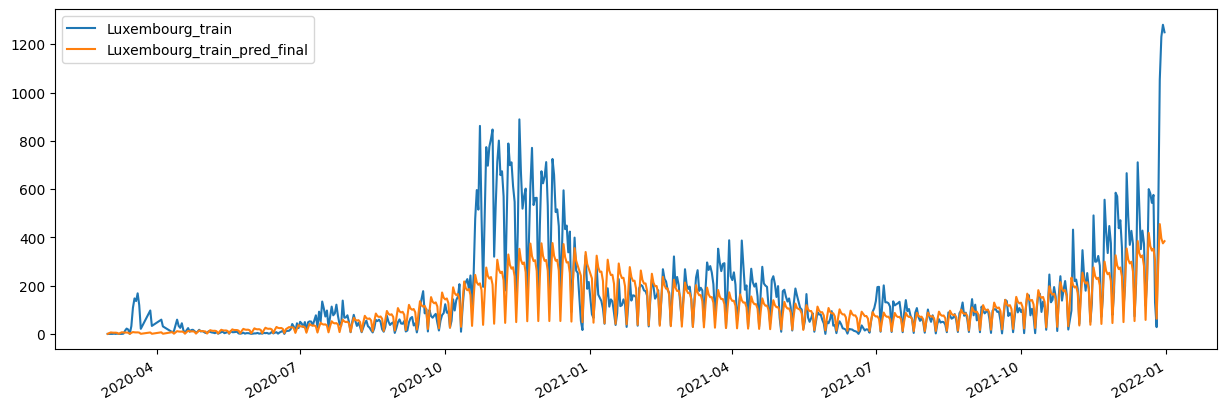

In [51]:
pd.concat([Luxembourg_train['new_confirmed'],Luxembourg_train_pred_final['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['Luxembourg_train', 'Luxembourg_train_pred_final'])

In [52]:
# Luxerberg final model training rmse
np.sqrt(mean_squared_error(Luxembourg_train['new_confirmed'],Luxembourg_train_pred_final['yhat']))

136.07675795109216

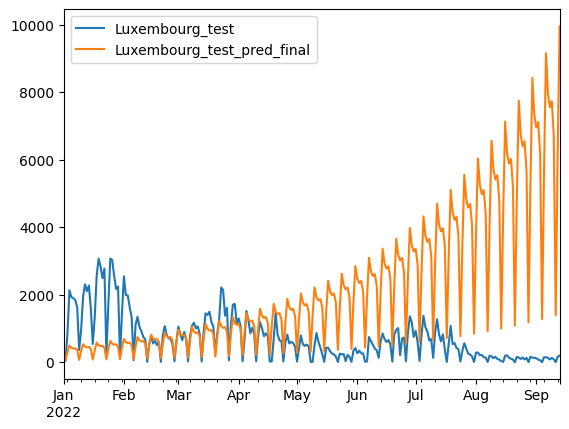

In [53]:
pd.concat([Luxembourg_test['new_confirmed'],Luxembourg_test_pred_final['yhat']], axis=1).plot( )
plt.legend(['Luxembourg_test', 'Luxembourg_test_pred_final'])

In [54]:
# Luxerberg final model test rmse
np.sqrt(mean_squared_error(Luxembourg_test['new_confirmed'],Luxembourg_test_pred_final['yhat']))

2844.297472031442

In [26]:
Singapore_train=process(Singapore_train)
Singapore_test=process(Singapore_test)
print(Singapore_train.shape, Singapore_test.shape)

(666, 22) (256, 22)


In [27]:
log_Singapore_train = np.log1p(Singapore_train)
log_Singapore_test = np.log1p(Singapore_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [28]:
log_Singapore_train.isnull().sum().sort_values(ascending = False)

mobility_workplaces                    544
lag1_new_confirmed                       0
dayofmonth                               0
dayofyear                                0
year                                     0
month                                    0
quarter                                  0
day_of_week                              0
gdp_per_capita_usd                       0
cumulative_persons_fully_vaccinated      0
new_persons_fully_vaccinated             0
new_confirmed                            0
life_expectancy                          0
area_sq_km                               0
longitude                                0
latitude                                 0
population_female                        0
population_male                          0
population                               0
cumulative_deceased                      0
new_deceased                             0
weekofyear                               0
dtype: int64

In [29]:
log_Singapore_train = log_Singapore_train.drop(['mobility_workplaces'],axis=1)
log_Singapore_test = log_Singapore_test.drop(['mobility_workplaces'],axis=1)

In [ ]:
model = prophet.Prophet(daily_seasonality=True)
for col in log_Singapore_train.columns:
    if col not in ['date', 'new_confirmed']:
        model.add_regressor(col)
Singapore_model=model.fit(log_Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedw9kchj/h715g0dz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedw9kchj/ofgya70w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45307', 'data', 'file=/tmp/tmpedw9kchj/h715g0dz.json', 'init=/tmp/tmpedw9kchj/ofgya70w.json', 'output', 'file=/tmp/tmpedw9kchj/prophet_model77zi3joa/prophet_model-20231126055726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:57:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:57:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


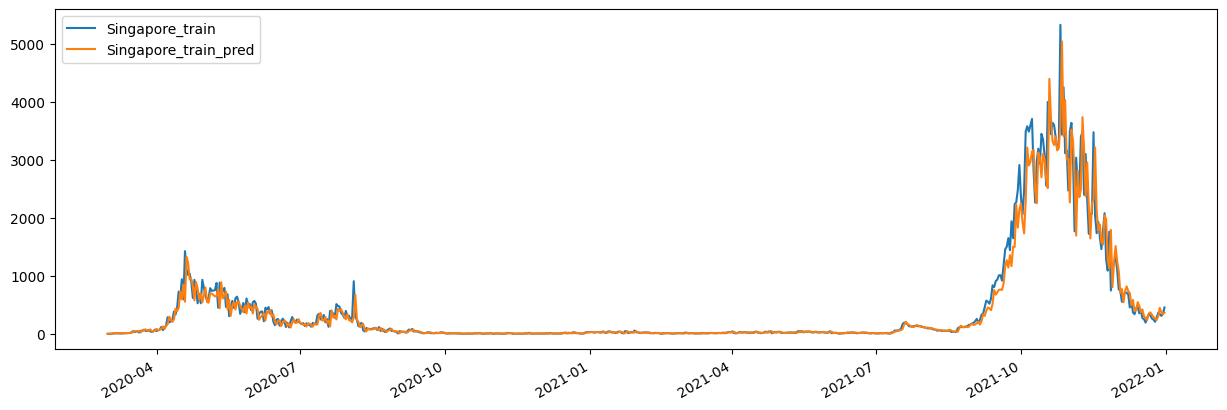

In [ ]:
Singapore_train_pred=np.exp(Singapore_model.predict(log_Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
pd.concat([Singapore_train['new_confirmed'],Singapore_train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['Singapore_train', 'Singapore_train_pred'])

In [ ]:
# Singapore model training rmse without tuning
np.sqrt(mean_squared_error(Singapore_train['new_confirmed'],Singapore_train_pred.yhat))

227.69414633847742

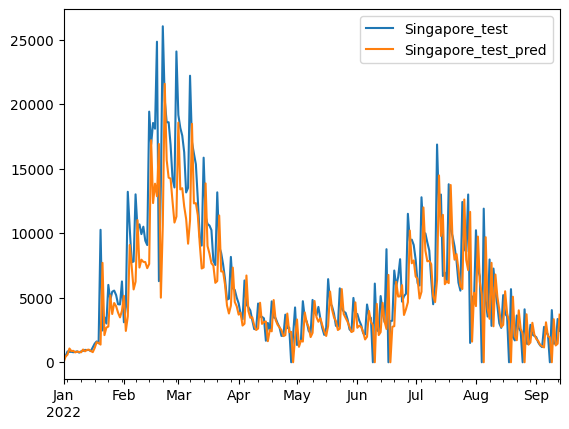

In [ ]:
Singapore_test_pred=np.exp(Singapore_model.predict(log_Singapore_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
pd.concat([Singapore_test['new_confirmed'],Singapore_test_pred['yhat']], axis=1).plot( )
plt.legend(['Singapore_test', 'Singapore_test_pred'])

In [ ]:
# Singapore model teset rmse without tuning
np.sqrt(mean_squared_error(Singapore_test['new_confirmed'],Singapore_test_pred['yhat']))

3416.1517833297307

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

cutoffs = pd.to_datetime(['2020-10-01', '2021-05-01', '2021-12-01'])
param_grid_option = {
    'changepoint_prior_scale': [0.001,0.003,0.03, 0.1, 0.2, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9],
    'seasonality_prior_scale': [0.01, 0.1, 0.5,1.0, 3,5, 8,10.0]}

all_params_combination = [dict(zip(param_grid_option.keys(), v)) for v in itertools.product(*param_grid_option.values())]
rmses = []

for parameters in all_params_combination:
    prophet_model = prophet.Prophet(**parameters,daily_seasonality=True).fit(log_Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    Singapore_cv = cross_validation(prophet_model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    Singapore_performance = performance_metrics(Singapore_cv, rolling_window=1)
    rmses.append(Singapore_performance['rmse'].values[0])

best_params = all_params_combination[np.argmin(rmses)]

In [ ]:
print(best_params)

{'changepoint_prior_scale': 0.003, 'seasonality_prior_scale': 1.0}


In [30]:
# Singapore model after tuning

Singapore_model_final = prophet.Prophet(changepoint_prior_scale = 0.003, seasonality_prior_scale = 1,daily_seasonality=True).fit(log_Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Singapore_train_pred_final=np.exp(Singapore_model_final.predict(log_Singapore_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
Singapore_test_pred_final=np.exp(Singapore_model_final.predict(log_Singapore_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/jpy33d4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/sg2_fcnu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2274', 'data', 'file=/tmp/tmp74ow6a8v/jpy33d4g.json', 'init=/tmp/tmp74ow6a8v/sg2_fcnu.json', 'output', 'file=/tmp/tmp74ow6a8v/prophet_modele0qg23en/prophet_model-20231126130032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


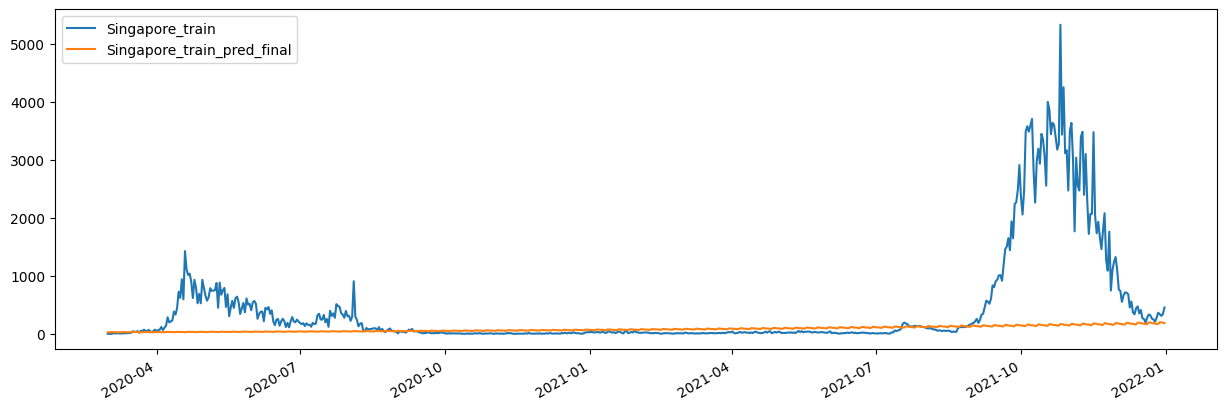

In [31]:
pd.concat([Singapore_train['new_confirmed'],Singapore_train_pred_final['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['Singapore_train', 'Singapore_train_pred_final'])

In [32]:
# Singapore final model training rmse
np.sqrt(mean_squared_error(Singapore_train['new_confirmed'],Singapore_train_pred_final['yhat']))

889.8422354844452

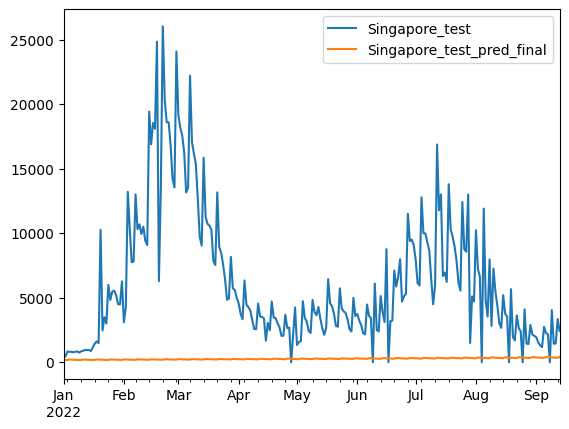

In [33]:
pd.concat([Singapore_test['new_confirmed'],Singapore_test_pred_final['yhat']], axis=1).plot( )
plt.legend(['Singapore_test', 'Singapore_test_pred_final'])

In [34]:
# Singapore final model test rmse
np.sqrt(mean_squared_error(Singapore_test['new_confirmed'],Singapore_test_pred_final['yhat']))

7853.824494998639

In [35]:
US_train=process(US_train)
US_test=process(US_test)
print(US_train.shape, US_test.shape)

(668, 22) (258, 22)


In [36]:
log_US_train = np.log1p(US_train)
log_US_test = np.log1p(US_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [37]:
log_US_train.isnull().sum().sort_values(ascending = False)

longitude                              668
mobility_workplaces                    655
new_persons_fully_vaccinated             0
dayofmonth                               0
dayofyear                                0
year                                     0
month                                    0
quarter                                  0
day_of_week                              0
gdp_per_capita_usd                       0
cumulative_persons_fully_vaccinated      0
new_confirmed                            0
lag1_new_confirmed                       0
life_expectancy                          0
area_sq_km                               0
latitude                                 0
population_female                        0
population_male                          0
population                               0
cumulative_deceased                      0
new_deceased                             0
weekofyear                               0
dtype: int64

In [38]:
log_US_train = log_US_train.drop(['longitude','mobility_workplaces'],axis=1)
log_US_test = log_US_test.drop(['longitude','mobility_workplaces'],axis=1)

In [ ]:
model = prophet.Prophet(daily_seasonality=True)
for col in log_US_train.columns:
    if col not in ['date', 'new_confirmed']:
        model.add_regressor(col)
US_model=model.fit(log_US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedw9kchj/qts9qgij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpedw9kchj/_xb2u9xe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56774', 'data', 'file=/tmp/tmpedw9kchj/qts9qgij.json', 'init=/tmp/tmpedw9kchj/_xb2u9xe.json', 'output', 'file=/tmp/tmpedw9kchj/prophet_modelkllak3tz/prophet_model-20231126060916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:09:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


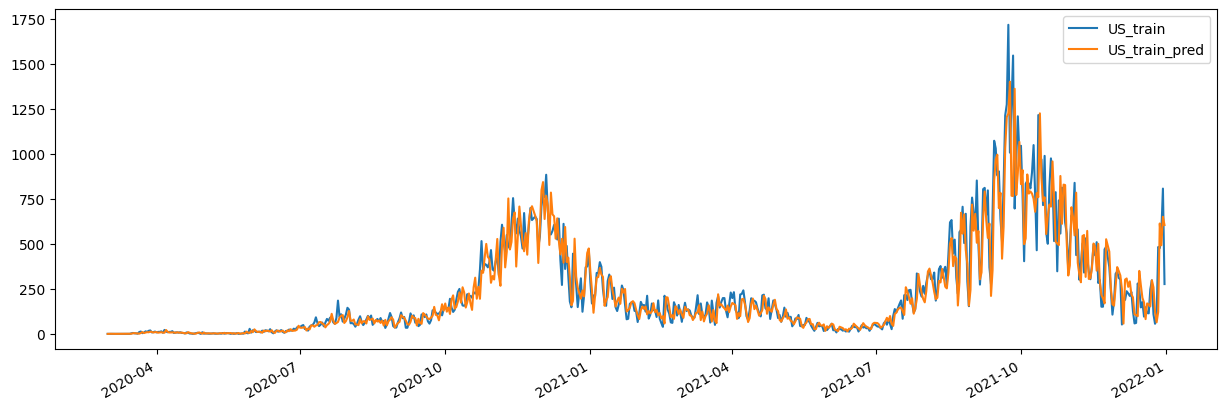

In [ ]:
US_train_pred=np.exp(US_model.predict(log_US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
pd.concat([US_train['new_confirmed'],US_train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['US_train', 'US_train_pred'])

In [ ]:
# US model training rmse without tuning
np.sqrt(mean_squared_error(US_train['new_confirmed'],US_train_pred.yhat))

99.84248337712481

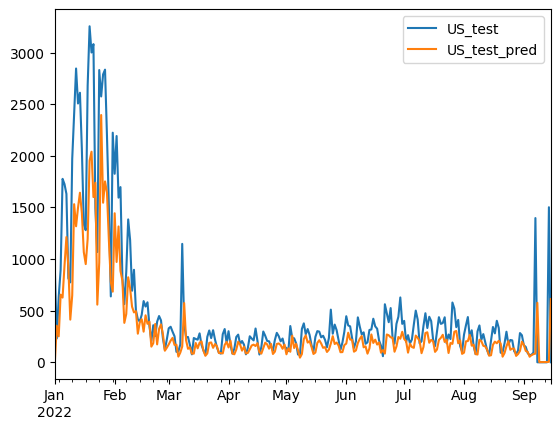

In [ ]:
US_test_pred=np.exp(US_model.predict(log_US_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
pd.concat([US_test['new_confirmed'],US_test_pred['yhat']], axis=1).plot( )
plt.legend(['US_test', 'US_test_pred'])

In [ ]:
# US model teset rmse without tuning
np.sqrt(mean_squared_error(US_test['new_confirmed'],US_test_pred['yhat']))

391.2097226924145

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

cutoffs = pd.to_datetime(['2020-10-01', '2021-05-01', '2021-12-01'])
param_grid_option = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 10.0]}

all_params_combination = [dict(zip(param_grid_option.keys(), v)) for v in itertools.product(*param_grid_option.values())]
rmses = []

for parameters in all_params_combination:
    prophet_model = prophet.Prophet(**parameters,daily_seasonality=True).fit(log_US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    US_cv = cross_validation(prophet_model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    US_performance = performance_metrics(US_cv, rolling_window=1)
    rmses.append(US_performance['rmse'].values[0])

best_params = all_params_combination[np.argmin(rmses)]

In [ ]:
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


In [39]:
# US model after tuning

US_model_final = prophet.Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 1,daily_seasonality=True).fit(log_US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
US_train_pred_final=np.exp(US_model_final.predict(log_US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
US_test_pred_final=np.exp(US_model_final.predict(log_US_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/rchk05ge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/s20imb2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61371', 'data', 'file=/tmp/tmp74ow6a8v/rchk05ge.json', 'init=/tmp/tmp74ow6a8v/s20imb2p.json', 'output', 'file=/tmp/tmp74ow6a8v/prophet_model61xtfzcv/prophet_model-20231126130054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


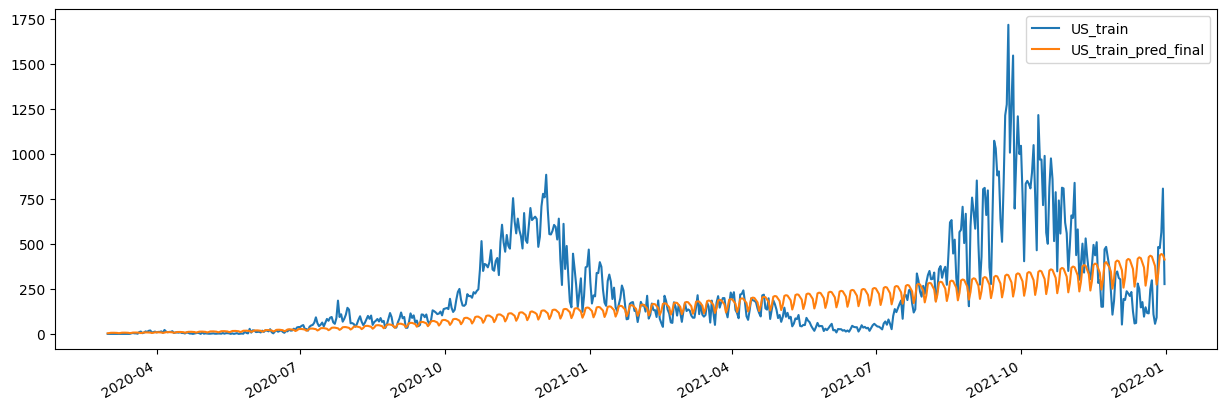

In [ ]:
pd.concat([US_train['new_confirmed'],US_train_pred_final['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['US_train', 'US_train_pred_final'])

In [ ]:
# US final model training rmse
np.sqrt(mean_squared_error(US_train['new_confirmed'],US_train_pred_final['yhat']))

238.56060438535891

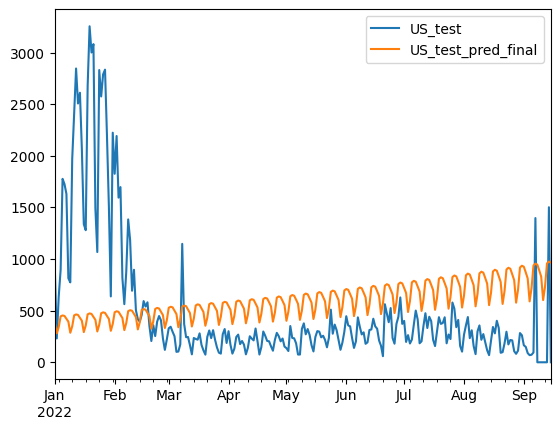

In [ ]:
pd.concat([US_test['new_confirmed'],US_test_pred_final['yhat']], axis=1).plot( )
plt.legend(['US_test', 'US_test_pred_final'])

In [ ]:
# US final model test rmse
np.sqrt(mean_squared_error(US_test['new_confirmed'],US_test_pred_final['yhat']))

724.5208811273244

In [40]:
Australia_train=process(Australia_train)
Australia_test=process(Australia_test)
print(Australia_train.shape,Australia_test.shape)

(666, 22) (261, 22)


In [41]:
log_Australia_train = np.log1p(Australia_train)
log_Australia_test = np.log1p(Australia_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [42]:
log_Australia_train.isnull().sum().sort_values(ascending = False)

latitude                               666
mobility_workplaces                    151
new_persons_fully_vaccinated             0
dayofmonth                               0
dayofyear                                0
year                                     0
month                                    0
quarter                                  0
day_of_week                              0
gdp_per_capita_usd                       0
cumulative_persons_fully_vaccinated      0
new_confirmed                            0
lag1_new_confirmed                       0
life_expectancy                          0
area_sq_km                               0
longitude                                0
population_female                        0
population_male                          0
population                               0
cumulative_deceased                      0
new_deceased                             0
weekofyear                               0
dtype: int64

In [43]:
log_Australia_train = log_Australia_train.drop(['latitude','mobility_workplaces'],axis=1)
log_Australia_test = log_Australia_test.drop(['latitude','mobility_workplaces'],axis=1)

In [ ]:
model = prophet.Prophet()
for col in log_Australia_train.columns:
    if col not in ['date', 'new_confirmed']:
        model.add_regressor(col)
Australia_model=model.fit(log_Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjognlpwn/k80q3hcz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjognlpwn/9h932mx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96327', 'data', 'file=/tmp/tmpjognlpwn/k80q3hcz.json', 'init=/tmp/tmpjognlpwn/9h932mx9.json', 'output', 'file=/tmp/tmpjognlpwn/prophet_modelce8z1u5r/prophet_model-20231125222444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:24:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1221: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['trend'] = self.predict_trend(df)


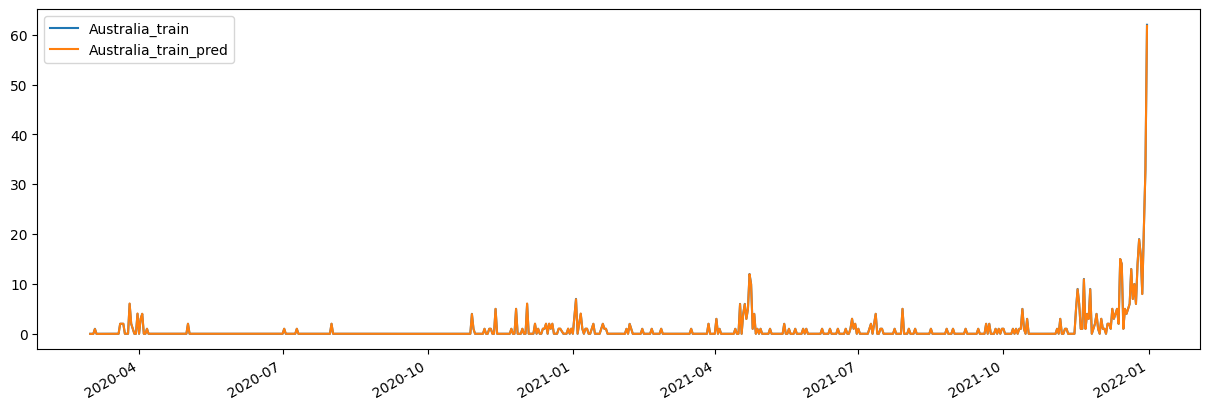

In [ ]:
Australia_train_pred=np.exp(Australia_model.predict(log_Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
pd.concat([Australia_train['new_confirmed'],Australia_train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['Australia_train', 'Australia_train_pred'])

In [ ]:
# Australia model training rmse without tuning
np.sqrt(mean_squared_error(Australia_train['new_confirmed'],Australia_train_pred.yhat))

0.017669586271500635

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1221: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['trend'] = self.predict_trend(df)


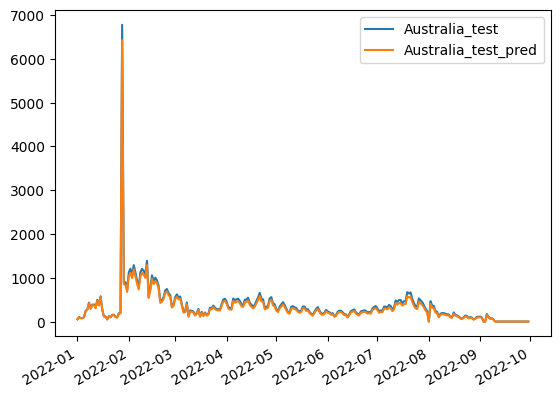

In [ ]:
Australia_test_pred=np.exp(Australia_model.predict(log_Australia_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
pd.concat([Australia_test['new_confirmed'],Australia_test_pred['yhat']], axis=1).plot( )
plt.legend(['Australia_test', 'Australia_test_pred'])

In [ ]:
# Australia model teset rmse without tuning
np.sqrt(mean_squared_error(Australia_test['new_confirmed'],Australia_test_pred['yhat']))

46.27377101554251

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

cutoffs = pd.to_datetime(['2020-10-01', '2021-05-01', '2021-12-01'])
param_grid_option = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.3,0.4, 0.5,0.6,0.7,0.8,0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 10.0]}

all_params_combination = [dict(zip(param_grid_option.keys(), v)) for v in itertools.product(*param_grid_option.values())]
rmses = []

for parameters in all_params_combination:
    prophet_model = prophet.Prophet(**parameters).fit(log_Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    Australia_cv = cross_validation(prophet_model, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    Australia_performance = performance_metrics(Australia_cv, rolling_window=1)
    rmses.append(Australia_performance['rmse'].values[0])

best_params = all_params_combination[np.argmin(rmses)]

In [ ]:
print(best_params)

{'changepoint_prior_scale': 0.9, 'seasonality_prior_scale': 10.0}


In [44]:
# Australia model after tuning

Australia_model_final = prophet.Prophet(changepoint_prior_scale = 0.9, seasonality_prior_scale = 10).fit(log_Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
Australia_train_pred_final=np.exp(Australia_model_final.predict(log_Australia_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1
Australia_test_pred_final=np.exp(Australia_model_final.predict(log_Australia_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds'))-1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/hhi1vwte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp74ow6a8v/xz3a2bnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79786', 'data', 'file=/tmp/tmp74ow6a8v/hhi1vwte.json', 'init=/tmp/tmp74ow6a8v/xz3a2bnw.json', 'output', 'file=/tmp/tmp74ow6a8v/prophet_model7lcl4jby/prophet_model-20231126130115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:01:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:01:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


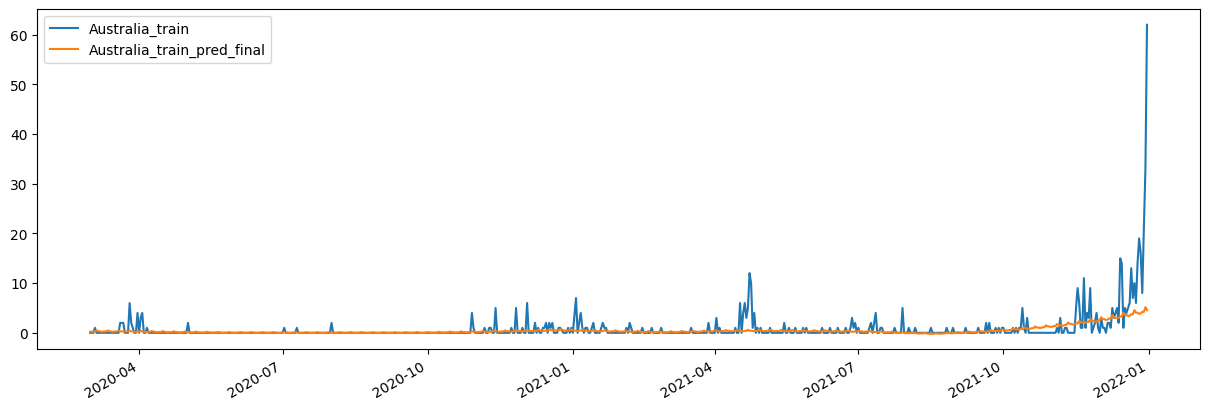

In [45]:
pd.concat([Australia_train['new_confirmed'],Australia_train_pred_final['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['Australia_train', 'Australia_train_pred_final'])

In [ ]:
# Australia final model training rmse
np.sqrt(mean_squared_error(Australia_train['new_confirmed'],Australia_train_pred_final['yhat']))

94.21369273829825

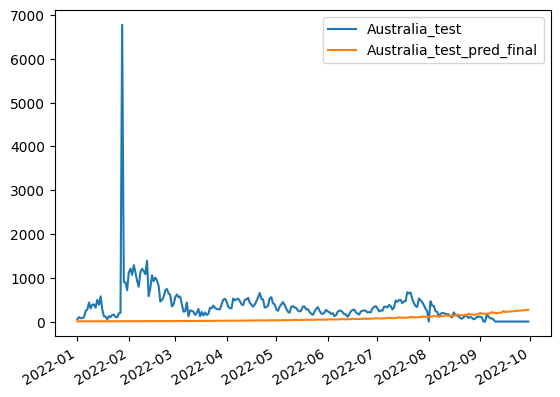

In [46]:
pd.concat([Australia_test['new_confirmed'],Australia_test_pred_final['yhat']], axis=1).plot( )
plt.legend(['Australia_test', 'Australia_test_pred_final'])

In [ ]:
# Australia final model test rmse
np.sqrt(mean_squared_error(Australia_test['new_confirmed'],Australia_test_pred_final['yhat']))

904.4193743534901

In [47]:
# apply to all countries
# Luxembourg_model_final for European countries
# Singapore_model_final for Asian countries
# US_model_final for countries in North America - only US in top 10
# Australia_model_final for Oceania countries - only Australia in top 10
Ireland_train = train.loc[train.country_code == 'IE'] # Europe
Ireland_train = Ireland_train.drop(['country_code','location_key_x'],axis=1)
Norway_train = train.loc[train.country_code == 'NO'] # Europe
Norway_train = Norway_train.drop(['country_code','location_key_x'],axis=1)
Switzerland_train = train.loc[train.country_code == 'CH'] # Europe
Switzerland_train = Switzerland_train.drop(['country_code','location_key_x'],axis=1)
Qatar_train = train.loc[train.country_code == 'QA'] # Asia
Qatar_train = Qatar_train.drop(['country_code','location_key_x'],axis=1)
Iceland_train = train.loc[train.country_code == 'IS'] # Europe
Iceland_train = Iceland_train.drop(['country_code','location_key_x'],axis=1)
Denmark_train = train.loc[train.country_code == 'DK'] # Europe
Denmark_train = Denmark_train.drop(['country_code','location_key_x'],axis=1)

Ireland_test = test.loc[test.country_code == 'IE'] # Europe
Ireland_test = Ireland_test.drop(['country_code','location_key_x'],axis=1)
Norway_test = test.loc[test.country_code == 'NO'] # Europe
Norway_test = Norway_test.drop(['country_code','location_key_x'],axis=1)
Switzerland_test = test.loc[test.country_code == 'CH'] # Europe
Switzerland_test = Switzerland_test.drop(['country_code','location_key_x'],axis=1)
Qatar_test = test.loc[test.country_code == 'QA'] # Asia
Qatar_test = Qatar_test.drop(['country_code','location_key_x'],axis=1)
Iceland_test = test.loc[test.country_code == 'IS'] # Europe
Iceland_test = Iceland_test.drop(['country_code','location_key_x'],axis=1)
Denmark_test = test.loc[test.country_code == 'DK'] # Europe
Denmark_test = Denmark_test.drop(['country_code','location_key_x'],axis=1)

In [55]:
Ireland_train=process(Ireland_train)
Ireland_test=process(Ireland_test)
print(Ireland_train.shape,Ireland_test.shape)

(666, 22) (256, 22)


In [58]:
log_Ireland_train = np.log1p(Ireland_train)
log_Ireland_test = np.log1p(Ireland_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [59]:
log_Ireland_train.isnull().sum().sort_values(ascending = False)

longitude                              666
mobility_workplaces                    569
new_persons_fully_vaccinated             0
dayofmonth                               0
dayofyear                                0
year                                     0
month                                    0
quarter                                  0
day_of_week                              0
gdp_per_capita_usd                       0
cumulative_persons_fully_vaccinated      0
new_confirmed                            0
lag1_new_confirmed                       0
life_expectancy                          0
area_sq_km                               0
latitude                                 0
population_female                        0
population_male                          0
population                               0
cumulative_deceased                      0
new_deceased                             0
weekofyear                               0
dtype: int64

In [60]:
log_Ireland_train = log_Ireland_train.drop(['longitude','mobility_workplaces'],axis=1)
log_Ireland_test = log_Ireland_test.drop(['longitude','mobility_workplaces'],axis=1)

In [62]:
# Ireland using Luxembourg final model
Ireland_train_pred_final=Luxembourg_model_final.predict(log_Ireland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Ireland_test_pred_final=Luxembourg_model_final.predict(log_Ireland_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [63]:
# Ireland training rmse
np.sqrt(mean_squared_error(Ireland_train['new_confirmed'],Ireland_train_pred_final['yhat']))

2496.346539774728

In [64]:
# Ireland test rmse
np.sqrt(mean_squared_error(Ireland_test['new_confirmed'],Ireland_test_pred_final['yhat']))

5675.847316161377

In [65]:
Norway_train=process(Norway_train)
Norway_test=process(Norway_test)

In [66]:
log_Norway_train = np.log1p(Norway_train)
log_Norway_test = np.log1p(Norway_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [67]:
log_Norway_train.isnull().sum().sort_values(ascending = False)

mobility_workplaces                    6476
lag1_new_confirmed                        0
dayofmonth                                0
dayofyear                                 0
year                                      0
month                                     0
quarter                                   0
day_of_week                               0
gdp_per_capita_usd                        0
cumulative_persons_fully_vaccinated       0
new_persons_fully_vaccinated              0
new_confirmed                             0
life_expectancy                           0
area_sq_km                                0
longitude                                 0
latitude                                  0
population_female                         0
population_male                           0
population                                0
cumulative_deceased                       0
new_deceased                              0
weekofyear                                0
dtype: int64

In [68]:
log_Norway_train = log_Norway_train.drop(['mobility_workplaces'],axis=1)
log_Norway_test = log_Norway_test.drop(['mobility_workplaces'],axis=1)

In [69]:
# Norway using Luxembourg final model
Norway_train_pred_final=Luxembourg_model_final.predict(log_Norway_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Norway_test_pred_final=Luxembourg_model_final.predict(log_Norway_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [70]:
# Norway training rmse
np.sqrt(mean_squared_error(Norway_train['new_confirmed'],Norway_train_pred_final['yhat']))

194.02389846792227

In [71]:
# Norway test rmse
np.sqrt(mean_squared_error(Norway_test['new_confirmed'],Norway_test_pred_final['yhat']))

1100.5569170824776

In [72]:
Switzerland_train=process(Switzerland_train)
Switzerland_test=process(Switzerland_test)

In [73]:
log_Switzerland_train = np.log1p(Switzerland_train)
log_Switzerland_test = np.log1p(Switzerland_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [74]:
log_Switzerland_train.isnull().sum().sort_values(ascending = False)

mobility_workplaces                    16059
lag1_new_confirmed                         0
dayofmonth                                 0
dayofyear                                  0
year                                       0
month                                      0
quarter                                    0
day_of_week                                0
gdp_per_capita_usd                         0
cumulative_persons_fully_vaccinated        0
new_persons_fully_vaccinated               0
new_confirmed                              0
life_expectancy                            0
area_sq_km                                 0
longitude                                  0
latitude                                   0
population_female                          0
population_male                            0
population                                 0
cumulative_deceased                        0
new_deceased                               0
weekofyear                                 0
dtype: int

In [82]:
log_Switzerland_train = log_Switzerland_train.drop(['mobility_workplaces'],axis=1)
log_Switzerland_test = log_Switzerland_test.drop(['mobility_workplaces'],axis=1)

In [83]:
# Switzerland using Luxembourg final model
Switzerland_train_pred_final=Luxembourg_model_final.predict(log_Switzerland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Switzerland_test_pred_final=Luxembourg_model_final.predict(log_Switzerland_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [84]:
# Switzerland training rmse
np.sqrt(mean_squared_error(Switzerland_train['new_confirmed'],Switzerland_train_pred_final['yhat']))

191.77328361352951

In [85]:
# Switzerland test rmse
np.sqrt(mean_squared_error(Switzerland_test['new_confirmed'],Switzerland_test_pred_final['yhat']))

882.3022776978717

In [79]:
Qatar_train=process(Qatar_train)
Qatar_test=process(Qatar_test)

In [80]:
log_Qatar_train = np.log1p(Qatar_train)
log_Qatar_test = np.log1p(Qatar_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [81]:
log_Qatar_train.isnull().sum().sort_values(ascending = False)

mobility_workplaces                    498
lag1_new_confirmed                       0
dayofmonth                               0
dayofyear                                0
year                                     0
month                                    0
quarter                                  0
day_of_week                              0
gdp_per_capita_usd                       0
cumulative_persons_fully_vaccinated      0
new_persons_fully_vaccinated             0
new_confirmed                            0
life_expectancy                          0
area_sq_km                               0
longitude                                0
latitude                                 0
population_female                        0
population_male                          0
population                               0
cumulative_deceased                      0
new_deceased                             0
weekofyear                               0
dtype: int64

In [86]:
log_Qatar_train = log_Qatar_train.drop(['mobility_workplaces'],axis=1)
log_Qatar_test = log_Qatar_test.drop(['mobility_workplaces'],axis=1)

In [87]:
# Qatar using Singapore final model
Qatar_train_pred_final=Singapore_model_final.predict(log_Qatar_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Qatar_test_pred_final=Singapore_model_final.predict(log_Qatar_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [89]:
# Qatar training rmse
np.sqrt(mean_squared_error(Qatar_train['new_confirmed'],Qatar_train_pred_final['yhat']))

535.827156128452

In [88]:
# Qatar test rmse
np.sqrt(mean_squared_error(Qatar_test['new_confirmed'],Qatar_test_pred_final['yhat']))

1175.012535686073

In [90]:
Iceland_train=process(Iceland_train)
Iceland_test=process(Iceland_test)

In [91]:
log_Iceland_train = np.log1p(Iceland_train)
log_Iceland_test = np.log1p(Iceland_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [92]:
log_Iceland_train.isnull().sum().sort_values(ascending = False)

mobility_workplaces                    671
longitude                              671
new_persons_fully_vaccinated             0
dayofmonth                               0
dayofyear                                0
year                                     0
month                                    0
quarter                                  0
day_of_week                              0
gdp_per_capita_usd                       0
cumulative_persons_fully_vaccinated      0
new_confirmed                            0
lag1_new_confirmed                       0
life_expectancy                          0
area_sq_km                               0
latitude                                 0
population_female                        0
population_male                          0
population                               0
cumulative_deceased                      0
new_deceased                             0
weekofyear                               0
dtype: int64

In [93]:
log_Iceland_train = log_Iceland_train.drop(['longitude','mobility_workplaces'],axis=1)
log_Iceland_test = log_Iceland_test.drop(['longitude','mobility_workplaces'],axis=1)

In [94]:
# Iceland using Luxembourg final model
Iceland_train_pred_final=Luxembourg_model_final.predict(log_Iceland_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Iceland_test_pred_final=Luxembourg_model_final.predict(log_Iceland_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [95]:
# Iceland training rmse
np.sqrt(mean_squared_error(Iceland_train['new_confirmed'],Iceland_train_pred_final['yhat']))

118.41345549380335

In [96]:
# Iceland test rmse
np.sqrt(mean_squared_error(Iceland_test['new_confirmed'],Iceland_test_pred_final['yhat']))

1122.5572444588354

In [97]:
Denmark_train=process(Denmark_train)
Denmark_test=process(Denmark_test)

In [98]:
log_Denmark_train = np.log1p(Denmark_train)
log_Denmark_test = np.log1p(Denmark_test)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [99]:
log_Denmark_train.isnull().sum().sort_values(ascending = False)

mobility_workplaces                    583
lag1_new_confirmed                       0
dayofmonth                               0
dayofyear                                0
year                                     0
month                                    0
quarter                                  0
day_of_week                              0
gdp_per_capita_usd                       0
cumulative_persons_fully_vaccinated      0
new_persons_fully_vaccinated             0
new_confirmed                            0
life_expectancy                          0
area_sq_km                               0
longitude                                0
latitude                                 0
population_female                        0
population_male                          0
population                               0
cumulative_deceased                      0
new_deceased                             0
weekofyear                               0
dtype: int64

In [100]:
log_Denmark_train = log_Denmark_train.drop(['mobility_workplaces'],axis=1)
log_Denmark_test = log_Denmark_test.drop(['mobility_workplaces'],axis=1)

In [101]:
# Denmark using Luxembourg final model
Denmark_train_pred_final=Luxembourg_model_final.predict(log_Denmark_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
Denmark_test_pred_final=Luxembourg_model_final.predict(log_Denmark_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')

In [102]:
# Denmark training rmse
np.sqrt(mean_squared_error(Denmark_train['new_confirmed'],Denmark_train_pred_final['yhat']))

2755.840822642611

In [103]:
# Denmark test rmse
np.sqrt(mean_squared_error(Denmark_test['new_confirmed'],Denmark_test_pred_final['yhat']))

17389.57344458539